In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#|default_exp train

# train

> Training images

In [4]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Core(TM) Ultra 7 155H)
Setup complete ✅ (22 CPUs, 15.3 GB RAM, 35.6/250.9 GB disk)


In [22]:
from ultralytics import YOLO
from IPython.display import display, Image
from minai import *
import fastcore.all as fc
from pilus_project.core import *
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torchvision.transforms import v2

In [5]:
set_seed(42)

In [6]:
path = Path.home()/'data/pili/training_data'
path.ls()

(#18) [Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.nd2'),Path('/home/kappa/data/pili/training_data/1hr01002.csv'),Path('/home/kappa/data/pili/training_data/0N01002.nd2'),Path('/home/kappa/data/pili/training_data/7.1- 003.nd2'),Path('/home/kappa/data/pili/training_data/0.1%.004.nd2'),Path('/home/kappa/data/pili/training_data/4hrs incu004.csv'),Path('/home/kappa/data/pili/training_data/1hr01002.nd2'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.nd2'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv'),Path('/home/kappa/data/pili/training_data/0N01002.csv'),Path('/home/kappa/data/pili/training_data/4hrs incu004.nd2'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.csv'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),Path('/home/kappa/data/pili/training_data/7.1- 003.csv'),Path('/hom

In [7]:
ims = L(path.glob('*.nd2'))
ims

(#9) [Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.nd2'),Path('/home/kappa/data/pili/training_data/0N01002.nd2'),Path('/home/kappa/data/pili/training_data/7.1- 003.nd2'),Path('/home/kappa/data/pili/training_data/0.1%.004.nd2'),Path('/home/kappa/data/pili/training_data/1hr01002.nd2'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.nd2'),Path('/home/kappa/data/pili/training_data/4hrs incu004.nd2'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.nd2')]

In [8]:
paths = [(im, im.with_suffix('.csv')) for im in ims]
paths

[(Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.nd2'),
  Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv')),
 (Path('/home/kappa/data/pili/training_data/0N01002.nd2'),
  Path('/home/kappa/data/pili/training_data/0N01002.csv')),
 (Path('/home/kappa/data/pili/training_data/7.1- 003.nd2'),
  Path('/home/kappa/data/pili/training_data/7.1- 003.csv')),
 (Path('/home/kappa/data/pili/training_data/0.1%.004.nd2'),
  Path('/home/kappa/data/pili/training_data/0.1%.004.csv')),
 (Path('/home/kappa/data/pili/training_data/1hr01002.nd2'),
  Path('/home/kappa/data/pili/training_data/1hr01002.csv')),
 (Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.nd2'),
  Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv')),
 (Path('/home/kappa/data/pili/training_data/4hrs incu004.nd2'),
  Path('/home/kappa/data/pili/training_data/4hrs incu004.csv')),
 (Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),
  Path('/home/kappa/data/pili/training_data/WT-A86C

In [9]:
csvs = L(path.glob('*.csv'))
csvs

(#9) [Path('/home/kappa/data/pili/training_data/1hr01002.csv'),Path('/home/kappa/data/pili/training_data/4hrs incu004.csv'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv'),Path('/home/kappa/data/pili/training_data/0N01002.csv'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.csv'),Path('/home/kappa/data/pili/training_data/7.1- 003.csv'),Path('/home/kappa/data/pili/training_data/0.1%.004.csv')]

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
trn_path, val_path = train_test_split(paths, test_size=0.2, random_state=42)
val_path

[(Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),
  Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv')),
 (Path('/home/kappa/data/pili/training_data/0N01002.nd2'),
  Path('/home/kappa/data/pili/training_data/0N01002.csv'))]

In [12]:
class PiliDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_files = list(Path(image_dir).glob('*.nd2'))
        self.transform = transform
        
    def __len__(self): return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = get_im(img_path)
        label_path = img_path.with_suffix('.csv')
        corners = calc_corners(str(label_path))
        
        if self.transform:
            img = self.transform(img)
            
        return img, corners

In [13]:
list(zip(*val_path))

[(Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),
  Path('/home/kappa/data/pili/training_data/0N01002.nd2')),
 (Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),
  Path('/home/kappa/data/pili/training_data/0N01002.csv'))]

TODO: Normalize with pretrained data statistics

In [14]:
tfm = v2.Compose([
    get_im,
    v2.ToImage(),
    v2.ConvertImageDtype(torch.float32),
    v2.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0]==1 else x),
    v2.Normalize(mean=[0.0048, 0.0048, 0.0048], std=[0.0138, 0.0138, 0.0138]), # statistics from data
])

In [15]:
def process_img(im): return tfm(get_im(im))

In [16]:
trn_ds = TfmDataset(*zip(*trn_path), tfm_x=tfm, tfm_y=calc_corners)
val_ds = TfmDataset(*zip(*val_path), tfm_x=tfm, tfm_y=calc_corners)
x, y = next(iter(trn_ds))
x.shape, y[:5]

(torch.Size([3, 1952, 1952]),
 tensor([[4.0000, 0.2166, 0.8646, 0.1645, 0.8972, 0.1545, 0.8812, 0.2066, 0.8486],
         [4.0000, 0.2334, 0.6836, 0.1811, 0.6986, 0.1753, 0.6781, 0.2275, 0.6632],
         [4.0000, 0.2122, 0.4038, 0.1546, 0.3905, 0.1585, 0.3732, 0.2161, 0.3865],
         [4.0000, 0.2814, 0.2086, 0.2660, 0.1467, 0.2855, 0.1418, 0.3009, 0.2038],
         [4.0000, 0.3904, 0.3313, 0.3666, 0.2960, 0.3813, 0.2861, 0.4051, 0.3214]], dtype=torch.float64))

In [28]:
x[0].shape

torch.Size([1952, 1952])

In [17]:
x.mean(), x.std()

(tensor(0.0597), tensor(1.4359))

In [18]:
# Getting the statistics of data
# imgs = [x for x,y in trn_ds]
# timgs = torch.stack(imgs)
# timgs.shape
# timgs.mean((0,2,3)), timgs.std((0,2,3))

In [29]:
@fc.delegates(plt.Axes.imshow)
def imshow_with_boxes(im, boxes, figsize=(8,8), **kwargs):
    import matplotlib.patches as patches
    colors = {
        1: 'red',    # GREEN YELLOW
        2: 'blue',   # TURQUOISE
        3: 'green',  # THISTLE 
        4: 'yellow', # COrAL
        5: 'purple', # WHITE
        6: 'orange'  # MAGENTA
    }
    class_names = {
        1: 'Type 1 - Both poles free',
        2: 'Type 2 - One pole occluded',
        3: 'Type 3 - Both poles occluded',
        4: 'Type 4 - Super bright cell',
        5: 'Type 5 - Very dim cell',
        6: 'Type 6 - Partial cell'
    }

    if im.shape[0]==3: im=im[0]
    height, width = im.shape[:2]
    fig, ax = plt.subplots(figsize=figsize)
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    plt.axis('off')

    unique_classes = boxes[:,0].unique().int().tolist()
    legend_elements = [patches.Patch(facecolor='none',
                                   edgecolor=colors[class_idx],
                                   label=class_names[class_idx])
                      for class_idx in unique_classes]

    for box in boxes:
        class_idx = box[0].item()
        corners = [[box[1].item() * width, box[2].item() * height],
                  [box[3].item() * width, box[4].item() * height],
                  [box[5].item() * width, box[6].item() * height],
                  [box[7].item() * width, box[8].item() * height]]

        color = colors.get(box[0].item(), 'white')
        polygon = patches.Polygon(corners, fill=False,
                                edgecolor=color,
                                linewidth=2)
        ax.add_patch(polygon)

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

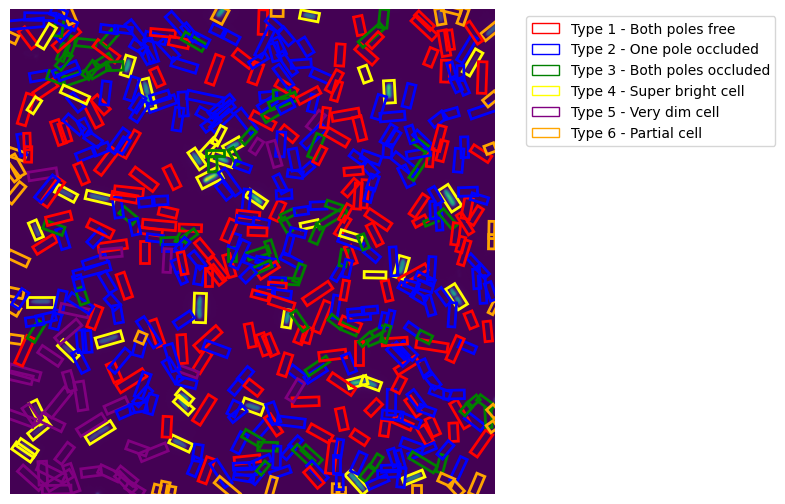

In [30]:
imshow_with_boxes(x, y)

In [31]:
bs=2

In [33]:
def collate_fn(batch):
    """Custom collate function to handle variable number of boxes"""
    imgs = torch.stack([item[0] for item in batch]) 
    boxes = [item[1] for item in batch]  
    return imgs, boxes

trn_dl, val_dl = dls = get_dls(trn_ds, val_ds, bs=bs, collate_fn=collate_fn)
xb,yb = next(iter(trn_dl))
xb.shape,yb[0]

(torch.Size([2, 3, 1952, 1952]),
 tensor([[4.0000, 0.9067, 0.2497,  ..., 0.2230, 0.9110, 0.2337],
         [4.0000, 0.4559, 0.3301,  ..., 0.2846, 0.4734, 0.3230],
         [4.0000, 0.5351, 0.3602,  ..., 0.3862, 0.5183, 0.3547],
         ...,
         [2.0000, 0.5490, 0.3630,  ..., 0.3476, 0.5499, 0.3500],
         [3.0000, 0.5057, 0.3783,  ..., 0.3380, 0.5198, 0.3793],
         [1.0000, 0.5676, 0.2528,  ..., 0.2573, 0.5592, 0.2413]], dtype=torch.float64))

In [34]:
import sys, gc, traceback, math, typing, random, numpy as np
from collections.abc import Mapping
from copy import copy
from itertools import zip_longest
from functools import partial, wraps
from operator import attrgetter, itemgetter

import matplotlib.pyplot as plt
import fastcore.all as fc
from fastprogress import progress_bar, master_bar

import torch, torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import default_collate

from torcheval.metrics import Mean

In [35]:
dls = DataLoaders(trn_dl, val_dl)
xb,yb = next(iter(dls.train))
xb.shape,yb[0]

(torch.Size([2, 3, 1952, 1952]),
 tensor([[4.0000, 0.6047, 0.6275,  ..., 0.6354, 0.5961, 0.6119],
         [4.0000, 0.8837, 0.5677,  ..., 0.5439, 0.8889, 0.5532],
         [4.0000, 0.9172, 0.5658,  ..., 0.5547, 0.9154, 0.5505],
         ...,
         [2.0000, 0.3974, 0.5584,  ..., 0.5284, 0.4149, 0.5611],
         [2.0000, 0.3731, 0.5784,  ..., 0.5460, 0.3905, 0.5750],
         [2.0000, 0.3765, 0.6015,  ..., 0.5685, 0.3929, 0.5989]], dtype=torch.float64))

In [41]:
# model.model.loss??

In [47]:
# loss_fn = model.model.init_criterion()
# loss_fn

In [65]:
# ultralytics.utils.loss.v8OBBLoss??

In [178]:
m = YOLO("yolo11n-obb.pt")
m.info()

YOLO11n-obb summary: 344 layers, 2,664,432 parameters, 0 gradients, 6.7 GFLOPs


(344, 2664432, 0, 6.7032192)

In [179]:
m.train??

In [177]:
torch.zeros(2, 0, 6)

tensor([], size=(2, 0, 6))

In [129]:
trainer = m._smart_load("trainer")
trainer.train??

In [ ]:
self.trainer = (trainer or self._smart_load("trainer"))(overrides=args, _callbacks=self.callbacks)

In [106]:
m.predict(xb)


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 6.105192184448242. Dividing input by 255.
0: 1952x1952 (no detections), 374.7ms
1: 1952x1952 (no detections), 374.7ms
Speed: 0.0ms preprocess, 374.7ms inference, 9.5ms postprocess per image at shape (1, 3, 1952, 1952)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 masks: None
 names: {0: 'plane', 1: 'ship', 2: 'storage tank', 3: 'baseball diamond', 4: 'tennis court', 5: 'basketball court', 6: 'ground track field', 7: 'harbor', 8: 'bridge', 9: 'large vehicle', 10: 'small vehicle', 11: 'helicopter', 12: 'roundabout', 13: 'soccer ball field', 14: 'swimming pool'}
 obb: ultralytics.engine.results.OBB object
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0

In [109]:
output = m.model(xb)
output[0].shape

torch.Size([2, 20, 78141])

In [110]:
len(output[1])

2

In [113]:
output[1]

([tensor([[[[  7.5614,   5.2504,   4.4035,  ...,   3.3120,   4.2859,   4.9485],
            [  7.6630,   5.7116,   3.7981,  ...,   2.7622,   3.7399,   5.2418],
            [  7.8397,   5.9465,   3.8716,  ...,   3.2238,   4.6919,   6.1895],
            ...,
            [  8.6113,   5.9353,   3.3653,  ...,   4.3949,   5.9693,   6.1774],
            [  8.4197,   5.5236,   2.9862,  ...,   3.7264,   5.4367,   5.7276],
            [  6.7875,   4.7538,   4.0702,  ...,   4.3565,   5.4665,   5.5462]],
  
           [[  6.6019,   5.6172,   4.5668,  ...,   3.8342,   3.9180,   5.1731],
            [  6.7415,   5.8273,   3.8304,  ...,   3.1859,   3.7346,   5.2093],
            [  6.8872,   6.4271,   4.2738,  ...,   3.8445,   4.7255,   5.6596],
            ...,
            [  7.5892,   6.4683,   3.8818,  ...,   4.7124,   5.5994,   5.5344],
            [  7.8173,   6.4860,   3.6392,  ...,   4.1967,   5.3906,   5.6892],
            [  6.3761,   5.8761,   4.3814,  ...,   4.8992,   5.6687,   5.7534]],
 

In [130]:
len(output[1][0]), len(output[1][1])

(3, 2)

In [133]:
output[1][0][0].shape, output[1][0][1].shape, output[1][0][2].shape

(torch.Size([2, 79, 244, 244]),
 torch.Size([2, 79, 122, 122]),
 torch.Size([2, 79, 61, 61]))

In [132]:
output[1][1][0].shape, output[1][1][1].shape

(torch.Size([1, 78141]), torch.Size([1, 78141]))

In [1]:
# learn.show_image_batch()